In [1]:
import torch 
import torch.nn as nn
import lightning as L

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt

from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import CSVLogger
from BalticRiverPrediction.convLSTM import ConvLSTM

from torch.utils.data import DataLoader, Dataset
from torch.utils.data.dataset import random_split

from BalticRiverPrediction.BaltNet import BaltNet, LightningModel
from BalticRiverPrediction.BaltNet import AtmosphereDataModule, AtmosphericDataset
from BalticRiverPrediction.sharedUtilities import read_netcdfs, preprocess, TaylorDiagram

In [2]:
# Set seed for reproducible
L.seed_everything(123)

# Use available tensor cores
torch.set_float32_matmul_precision("high")

# X 
datapath="/silor/boergel/paper/runoff_prediction/data"
datapathPP="/fast/boergel/paper/runoff_prediction"

# runoff = xr.open_dataset(f"{datapathPP}/runoff.nc").load()
# runoff = runoff.roflux

DataRain = xr.open_dataset(f"{datapathPP}/rain2.nc")
DataRain = DataRain.sel(time=slice("2011", "2014"))
DataRain = DataRain.RAIN.squeeze()

DataShumi = xr.open_dataset(f"{datapathPP}/shumi.nc")
DataShumi = DataShumi.sel(time=slice("2011", "2014"))
DataShumi = DataShumi.shumi.squeeze()

DataWindMagnitude = xr.open_dataset(f"{datapathPP}/windxy.nc")
DataWindMagnitude['wind_magnitude'] = (DataWindMagnitude['windx']**2 + DataWindMagnitude['windy']**2)**0.5
DataWindMagnitude = DataWindMagnitude.sel(time=slice("2011", "2014"))
DataWindMagnitude = DataWindMagnitude.wind_magnitude.squeeze(dim="height", drop=True)

assert DataShumi.time[0] == DataRain.time[0] == DataWindMagnitude.time[0]
assert len(DataShumi.time) == len(DataRain.time) == len(DataWindMagnitude.time)

data = xr.merge([DataRain, DataShumi, DataWindMagnitude])

runoff = read_netcdfs(
    f"{datapath}/runoffData/combined_fastriver_*.nc",
    dim="river",
    transform_func= lambda ds:ds.sel(time=slice(str(2011), str(2014))).roflux.resample(time="1D").mean(),
    cftime=False
    )  

assert len(runoff.time) == len(data.time)

modelParameters = {
    "input_dim": 3,
    "hidden_dim": 6,
    "kernel_size": (7,7),
    "num_layers": 2,
    "batch_first": True,
    "bias": True,
    "return_all_layers": False,
    "dimensions": (191, 206),
    "input_size": 30
}

Global seed set to 123
100%|█████████████████████████████████████████████████████████████████████████| 97/97 [00:35<00:00,  2.75it/s]


Config defines the setup of the model and the input data it expects. This will also affect the dataLoader. DataLoader automatically create batches of data and also put the data onto the GPU efficiently.

In [3]:
# Loads the atmospheric data in batches
dataLoader = AtmosphereDataModule(
atmosphericData=data,
runoff=runoff,
batch_size=64,
input_size=modelParameters["input_size"],
num_workers=8
)

num_epochs = 40
pyTorchBaltNet = BaltNet(modelPar=modelParameters)


In [4]:
LightningBaltNet = LightningModel.load_from_checkpoint(
        checkpoint_path=f"/silor/boergel/paper/runoff_prediction/data/modelWeights/ModelWeight_H6_K(7x7)_I30_L2TopOne-v1.ckpt",
        learning_rate=1e-6,
        model=pyTorchBaltNet
    )

In [5]:
dataDataset = AtmosphericDataset(
    atmosphericData=data.sel(time=slice(str(2011), str(2014))),
    runoff=runoff,
    input_size=modelParameters["input_size"],
)

tensor([[[[-0.6130, -0.6050, -0.5845,  ..., -0.5089, -0.5067, -0.5636],
          [-0.5705, -0.5682, -0.5631,  ..., -0.5046, -0.5289, -0.5111],
          [-0.5897, -0.6071, -0.6308,  ..., -0.4773, -0.4993, -0.4886],
          ...,
          [-0.5736, -0.5637, -0.5533,  ..., -0.4914, -0.4620, -0.4337],
          [-0.5697, -0.5601, -0.5519,  ..., -0.4807, -0.4330, -0.4105],
          [-0.5697, -0.5590, -0.5501,  ..., -0.4576, -0.3970, -0.3798]],

         [[-1.5554, -1.5514, -1.5446,  ..., -1.1903, -1.1768, -1.1717],
          [-1.5942, -1.5715, -1.5533,  ..., -1.2104, -1.1909, -1.1912],
          [-1.6074, -1.5842, -1.5723,  ..., -1.2223, -1.2133, -1.2230],
          ...,
          [-1.7719, -1.7800, -1.7864,  ..., -1.2445, -1.2515, -1.2542],
          [-1.7644, -1.7728, -1.7791,  ..., -1.2532, -1.2556, -1.2567],
          [-1.7581, -1.7659, -1.7729,  ..., -1.2634, -1.2619, -1.2649]],

         [[-0.5855, -0.5630, -0.4656,  ...,  2.8799,  2.3554,  2.3218],
          [-0.5140, -0.5242, -

In [6]:
predict_dataloader = DataLoader(
    dataDataset,
    batch_size=64,
    shuffle=False,
    drop_last=True
    )

In [7]:
trainer = L.Trainer(
    inference_mode=True,
    accelerator="cuda",
    devices=1,
    deterministic=True,
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [8]:
predictions = trainer.predict(LightningBaltNet, dataloaders=predict_dataloader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/silos/conda_packages/boergel/miniconda3_4.12.0/OS_15.4/conda_env/BaltNet/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:442: PossibleUserWarning: The dataloader, predict_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 96 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 0it [00:00, ?it/s]

In [10]:
dataDataset.runoffDataStats

(<xarray.DataArray 'roflux' (river: 97)>
 array([  33.61064022,   45.5155829 ,  644.76945528,   47.30555665,
          13.02240114,   62.08561069,   23.23847379, 1056.46820224,
          37.35323859,   16.02982998,   19.41510331,    7.7749602 ,
         139.33485787,   27.61420583,   42.08064771,  680.88160428,
          71.91132178,   72.46768874,   95.00392967,   36.6497767 ,
          83.56748792,  137.50105474,   61.94603035,  848.44849963,
          11.52980993,   63.63357766,   97.43116146,  127.99903246,
         102.67240485,   29.07433139,  613.86810687,   29.15462786,
          37.55781373,   42.92193174,   16.8902669 ,   70.18849514,
          42.28783115,   16.70045765,    5.06827712,  122.62002625,
          58.64941883,   66.70338796,   21.55336848,  520.30996003,
         288.34406503,  964.68548821,  238.4712004 ,   23.00773477,
         457.17208831,   35.16111723,   20.56423863,  136.16178322,
          31.80173507,   29.61480867,   17.32977089,   32.33453867,
       

In [11]:
concatenated_predictions = torch.cat(predictions, dim=0)
rescaledRunoffData = concatenated_predictions*dataDataset.runoffDataStats[1].data+dataDataset.runoffDataStats[0].data

In [12]:
origianlRunoffData = runoff.transpose("time", "river")
origianlRunoffData = origianlRunoffData.resample(time="1D").mean()

In [14]:
rescaledRunoffDataDataset = xr.DataArray(
    data = rescaledRunoffData.data,
    coords={
        "time": origianlRunoffData.time[modelParameters["input_size"]:],
        "river": origianlRunoffData.river
    }
)


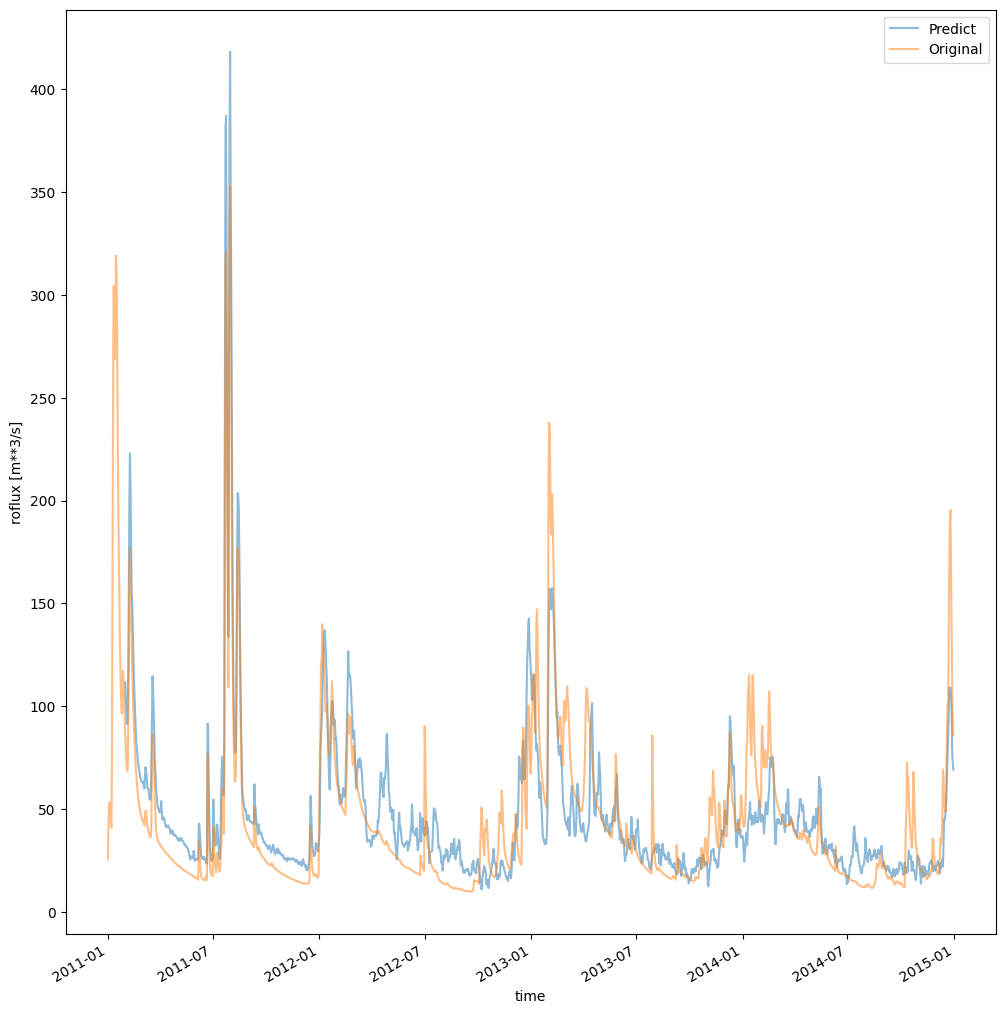

In [15]:
f, ax = plt.subplots(1, figsize=(12,12))
rescaledRunoffDataDataset.isel(river=1).plot(ax=ax, label = "Predict", alpha=.5)
origianlRunoffData.isel(river=1).plot(ax=ax, label="Original", alpha=0.5)
plt.legend()

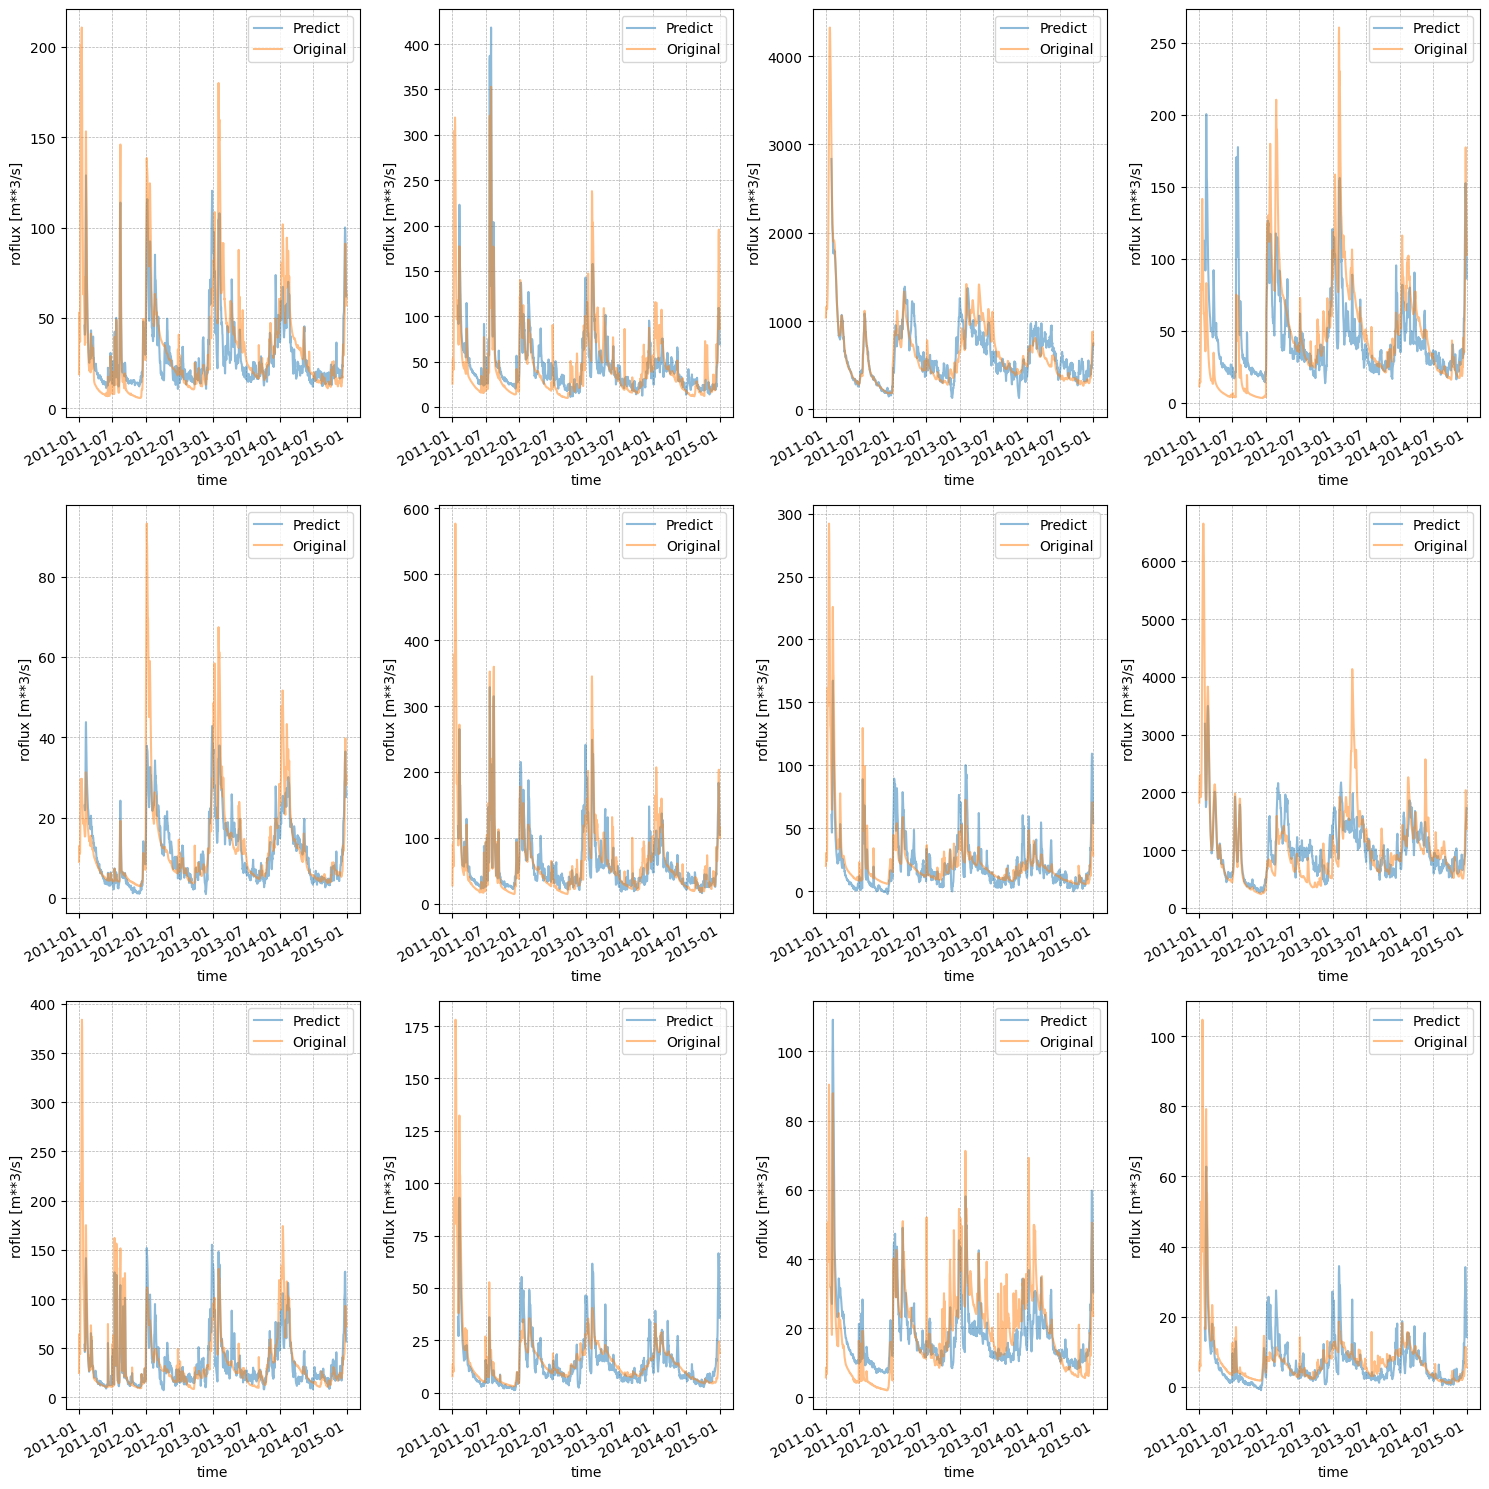

In [17]:
f, axs = plt.subplots(3,4, figsize=(15, 15))

for i, ax in enumerate(axs.ravel()):
    ax.set_title(f"River {i+1}")
    rescaledRunoffDataDataset.isel(river=i).plot(ax=ax, label = "Predict", alpha=.5)
    origianlRunoffData.isel(river=i).plot(ax=ax, label="Original", alpha=0.5)
    ax.legend()
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
plt.tight_layout()


In [18]:
class TaylorDiagram(object):
    """
    Taylor diagram.
    Plot model standard deviation and correlation to reference (data)
    sample in a single-quadrant polar plot, with r=stddev and
    theta=arccos(correlation).
    """
    def __init__(self, refdata, ax,  *args, **kwargs):
        # memorize reference data
        self.refdata = refdata
        self.ax = ax
        refstd = refdata.std(ddof=1) 
        rlim = [0.0, 1.2*refstd]
        thetalim = [0.0, 0.5*np.pi]
        if ax != None:
            # Add reference point and stddev contour
            try:
                kwargs["marker"]
            except:
                kwargs["marker"] = 'o'
            try:
                kwargs["color"]
            except:
                kwargs["color"] = "black"
            try:
                kwargs["ms"]
            except:
                kwargs["ms"] = 10     
            try:
                kwargs["label"]
            except:
                kwargs["label"] = "reference"                     
            ax.plot([0], refstd, *args, ls='', zorder=0, **kwargs)
            ax.grid(True, linestyle="--")
            
            ax.set_xlabel("St. dev.")
            ax.xaxis.set_label_coords(0.5, -0.1)
            ax.set_xlim(thetalim)
            ax.set_ylim(rlim)
            self.rlim = rlim
            self.thetalim = thetalim
        self.model_std = {"reference" : refstd}
        self.corrcoef = {"reference" : 1.0}
        self.rms = {"reference" : 0.0}
    def add_sample(self, model_data, *args, **kwargs):
        """
        Add sample to the Taylor
        diagram. *args* and *kwargs* are directly propagated to the
        `Figure.plot` command.
        """
        model_std = model_data.std(ddof=1)
        corrcoef = np.corrcoef(model_data, self.refdata)[0, 1]
        rms = np.sqrt(self.model_std["reference"]**2 + model_std**2 - 2.0*self.model_std["reference"]*model_std*np.cos(np.arccos(corrcoef)))
        try:
            label = kwargs["label"]
        except:
            label = "model"+str(len(self.model_std.keys())) 
        if self.ax != None:
            self.ax.plot(np.arccos(corrcoef), model_std,
                            *args, **kwargs)  # (theta, radius)
            if model_std > self.rlim[1]:
                self.rlim = [0, 1.2 * model_std]
                self.ax.set_ylim(*self.rlim)
            if np.arccos(corrcoef) > self.thetalim[1]:
                self.thetalim[1] = 1.2 * np.arccos(corrcoef)
                self.ax.set_xlim(*self.thetalim)                       
        self.model_std[label] = model_std
        self.corrcoef[label] = corrcoef
        self.rms[label] = rms
        #self.ax.set_ylim(rlim) 
    def get_samples(self):
        return self.model_std, self.corrcoef, self.rms
    def finalize(self):
        
        if self.ax is None:
            return 
        self.ax.text(0.5*(self.thetalim[1]-self.thetalim[0]), (1.0+0.03*(self.thetalim[1]-self.thetalim[0])**2)*self.rlim[1],"Correlation", rotation=0.5*(self.thetalim[1]-self.thetalim[0])*180.0/np.pi-90.0)
        rs, ts = np.meshgrid(np.linspace(*self.rlim), np.linspace(*self.thetalim))
        rms = np.sqrt(self.model_std["reference"]**2 + rs**2 - 2.0*self.model_std["reference"]*rs*np.cos(ts))
        self.ax.contourf(ts, rs, rms, 9, alpha=0.3, cmap="RdYlGn_r")
        contours = self.ax.contour(ts, rs, rms, 9, linestyles="--", linewidths=1, alpha=0.5, colors="grey")
        if self.model_std["reference"] > 100.0 or self.model_std["reference"] < 0.1:
            fmt = '%3.2e'
        else:
            fmt = '%3.2f'
        self.ax.clabel(contours, inline=False, fmt=fmt, colors="black")
        t = np.linspace(*self.thetalim)
        r = np.zeros_like(t) + self.model_std["reference"]
        self.ax.plot(t, r, 'k--', label='_')
        xticks = [1.0, 0.99, 0.95, 0.9, 0.8, 0.7, 0.6, 0.4, 0.2, 0.0]
        if self.thetalim[1] > 0.5*np.pi:
            for x in [-0.2, -0.4, -0.6, -0.8, -0.9, -0.95, -0.99 -1.0]:
                if np.arccos(x) > self.thetalim[1]:
                    break
                xticks += [x]
        self.ax.set_xticks(np.arccos(xticks))
        self.ax.set_xticklabels(xticks)

In [19]:
orignalTaylor = origianlRunoffData.sel(time=slice(rescaledRunoffDataDataset.time.min(), None)).isel(river=0)
modelPrediction = rescaledRunoffDataDataset.isel(river=0)

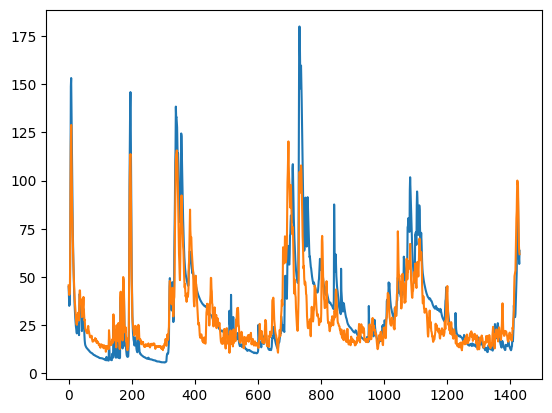

In [20]:
f, ax = plt.subplots(1)
ax.plot(orignalTaylor.data)
ax.plot(modelPrediction.data)

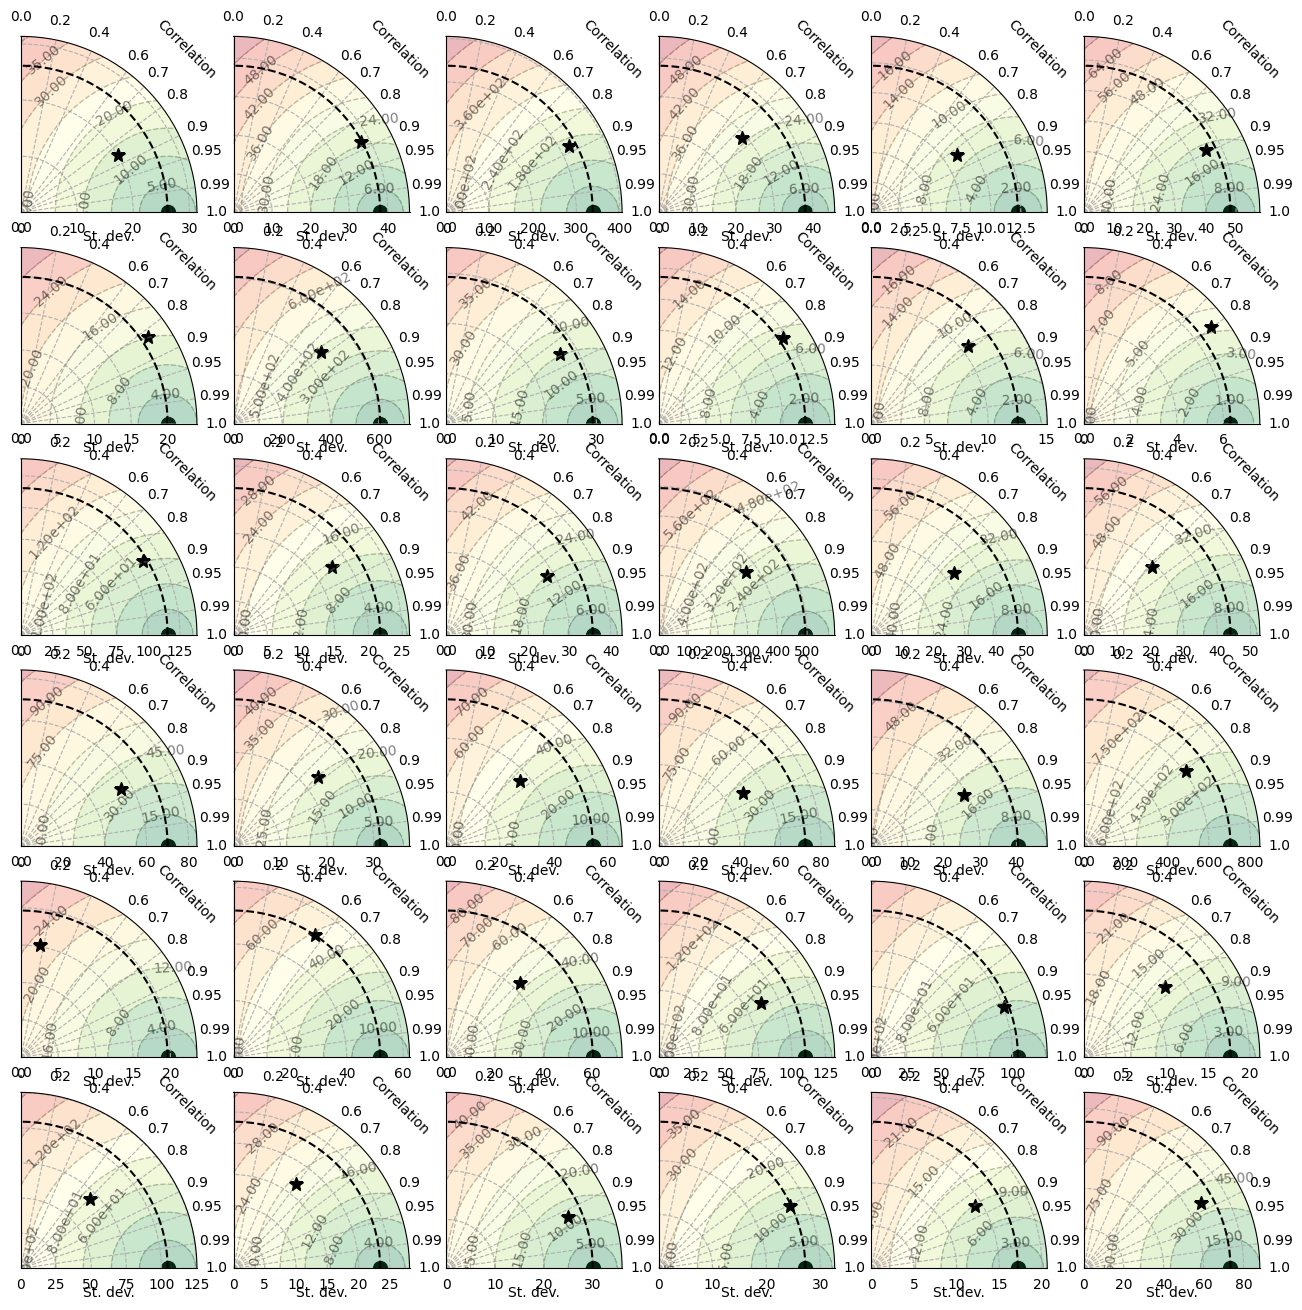

In [43]:
f, axes = plt.subplots(6,6, figsize=(16,16), subplot_kw={'projection': 'polar'})

for i,ax in enumerate(axes.ravel()):
    orignalTaylor = origianlRunoffData.sel(time=slice(rescaledRunoffDataDataset.time.min(), None)).isel(river=i)
    modelPrediction = rescaledRunoffDataDataset.isel(river=i)   
    diagram = TaylorDiagram(orignalTaylor.data, ax)
    diagram.add_sample(modelPrediction.data, marker='*', ms=10, ls='', color="black", label="River 0")
    diagram.finalize()